<a id='home'></a>
### purpose

fit output models to climate of common garden as well as future climate projections

### outline

[1 - create mask files using species' shapefiles for use in gradient forest fitting](#create)
- values inside of the shapefile boundares are set to 0 and all values outside of boundary are NA
    - save each mask (a RasterStack R object) (one for each species) as .RDS

[2 - rsync training outfiles from cedar HPC](#rsync)
- these are the RDS files created from using the input files created in `04_create_datasets-wza_baypass_random` with the scripts created in `05_gradient_forest_processing_scripts` which were carried out on cedar HPC

[3 - Read in common garden climate data](#climate)
- read in the two-year average climate for Vancouver common garden (doug-fir) and 52-year average climate for two jack pine common gardens (Ste Christine, Fontbrune)

[4 - Create common garden range_files](#range)
- if I want to project offset to a common garden for range-wide populations, I need to project the garden's climate range-wide
- do so by taking one of the clipped climate .txt files from `03_clip_climate_data.ipynb` for each of the species, and overwritting the range-wide climate data with the common garden data (all lat/longs within boundary species range get one climate value)

[5 - Fit trained model to common garden and future climates](#fit)


#### notes
- for the first revision of our manuscript, we now remove Elevation as an environmental variable with which to use for offest estimation
- I ran it through once with 56 engines but killed it once it started training parallel because of memory issues. Progress bars for rsycing will not be accurate
- unexpected consequence of using TD for creating mask files - because I used TD.tif to create mask files for fitting script (below, for script see ../05_gradient_forest_processing_scripts.ipynb), metadata within the mask file stored the TD file name, this metadata (just the name) was passed to the netCDF file output when fitting GF models to future climates. The maskfiles all had 0 values input within clipped ranges, and NA elsewhere (see below). Because I used the maskfile to extract XY coords corresponding to lat/long coords, and then put offset values into these coords (fitting script from 05.ipynb), the final gf.nc file maintained the TD file name in the metadata. I may have noticed this when creating the files, but since I didn't note it I scared myself at the end of the project and had to go back and look through code to make sure I didn't muck anything up. In the future, the simple thing would just be to replace the maskfile metadata. this metadata can be found by using python: ds = xarray.open_dataset(ncfile); ds.variables

In [1]:
from pythonimports import *
import xarray, rioxarray

lview,dview = get_client()

latest_commit()
sinfo(html=True)

56 56
##################################################################
Today:	June 26, 2023 - 07:20:25
python version: 3.8.5
conda env: newpy385

Current commit of pythonimports:
commit 03d76f7a992130f4b94ac34a09ad439e918d3044  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Fri Jun 9 09:42:21 2023 -0400
##################################################################



In [1]:
from pythonimports import *
import xarray, rioxarray

lview,dview = get_client()

latest_commit()
sinfo(html=True)

56 56
##################################################################
Today:	June 20, 2023 - 06:46:23
python version: 3.8.5
conda env: newpy385

Current commit of pythonimports:
commit 03d76f7a992130f4b94ac34a09ad439e918d3044  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Fri Jun 9 09:42:21 2023 -0400
##################################################################



<a id='create'></a>
# 1. create mask files

- this process based on code here: https://www.mountainmanmaier.com/software/pop_genom/
- I only really need one .tif (since I set all values to 0 to create mask)

outline
- first create a single .tif for each of the updated shapefiles
- then create and save RasterStack objects as RDS, where all values within shapefile boundaries are set to 0 and those outside are NA

[top](#home)

In [2]:
def create_tif(netcdf_file, tif_outfile, shapefile):
    """Clip netCDF file within shapefile boundaries, save as tif.
    
    Notes
    -----
    - assumes WGS84 projection of netcdf_file
    """
    import geopandas, rioxarray, cartopy.crs, xarray
    from shapely.geometry import box, mapping

    # read in netcdf file
    dataset = xarray.open_dataset(netcdf_file)

    # add metadata for WGS84
    dataset.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
    dataset.rio.write_crs("epsg:4326", inplace=True)

    # read in the shapefile
    shp = geopandas.read_file(shapefile, crs=cartopy.crs.PlateCarree())
    
    # clip climate data within boundaries of shapefile
    clipped = dataset.rio.clip(shp.geometry.apply(mapping), shp.crs, drop=False)
    
    # save as .tif
    clipped.rio.to_raster(tif_outfile)
    
    return tif_outfile

In [3]:
# get one of the netCDF files from one of the netCDF dirs created in ../02_update_species_range_shapefiles.ipynb
netdir = '/data/projects/pool_seq/environemental_data/new_netCDF_files/NA_ENSEMBLE_rcp45_2050s'
netfile = op.join(netdir, 'TD_WGS84.nc')
assert op.exists(netfile)

In [4]:
# get the paths to the updated shapefiles
shapedir = '/data/projects/pool_seq/environemental_data/shapefiles'
bnames = ['interior_union_file.shp',
          'combined/df_combined_union_file.shp',
          'jp_union_file.shp',
          'wl_union_file.shp',
          'coastal_union_file.shp']
shapefiles = [op.join(shapedir, f) for f in bnames]
shapefiles

['/data/projects/pool_seq/environemental_data/shapefiles/interior_union_file.shp',
 '/data/projects/pool_seq/environemental_data/shapefiles/combined/df_combined_union_file.shp',
 '/data/projects/pool_seq/environemental_data/shapefiles/jp_union_file.shp',
 '/data/projects/pool_seq/environemental_data/shapefiles/wl_union_file.shp',
 '/data/projects/pool_seq/environemental_data/shapefiles/coastal_union_file.shp']

In [5]:
# create a tif for each shapefile 
jobs = []
for shapefile in shapefiles:
    suffix = '_clipped_' + op.basename(shapefile).split("_union")[0] + '.tif'  # _clipped_<species>.tif
    outfile = netfile.replace('.nc', suffix)
    jobs.append(
        lview.apply_async(create_tif, *(netfile,
                                        outfile,
                                        shapefile))
        )
watch_async(jobs, desc='creating tifs')


Watching 5 jobs ...


creating tifs: 100%|███████████████| 5/5 [00:03<00:00,  1.35it/s]


In [6]:
tifs = []
for j in jobs:
    tifs.append(j.r)
    
tifs

['/data/projects/pool_seq/environemental_data/new_netCDF_files/NA_ENSEMBLE_rcp45_2050s/TD_WGS84_clipped_interior.tif',
 '/data/projects/pool_seq/environemental_data/new_netCDF_files/NA_ENSEMBLE_rcp45_2050s/TD_WGS84_clipped_df_combined.tif',
 '/data/projects/pool_seq/environemental_data/new_netCDF_files/NA_ENSEMBLE_rcp45_2050s/TD_WGS84_clipped_jp.tif',
 '/data/projects/pool_seq/environemental_data/new_netCDF_files/NA_ENSEMBLE_rcp45_2050s/TD_WGS84_clipped_wl.tif',
 '/data/projects/pool_seq/environemental_data/new_netCDF_files/NA_ENSEMBLE_rcp45_2050s/TD_WGS84_clipped_coastal.tif']

In [7]:
len(shapefiles) == len(jobs) == len(tifs)

True

In [8]:
# execute rsync commands from local computer to download the tif files

rsyncfile = '/lu213/brandon.lind/data/testdir/rsync_tifs.txt'

with open(rsyncfile, 'w') as o:
    cmds = []
    for tif in tifs:
        dname = op.basename(op.dirname(tif))
        cmds.append(f'rsync -azv yeaman03:{tif} {dname}-{op.basename(tif)}')

    o.write('\n'.join(cmds))

rsyncfile

'/lu213/brandon.lind/data/testdir/rsync_tifs.txt'

### create RasterStack from .tif and save
- values within the range boundaries are 0, outside the range boundaries are NA
- this is the effective process carried out here: https://www.mountainmanmaier.com/software/pop_genom/

```R
# first rsync clipped environmental .tif files created above

# then run the following on local computer that allows rgdal install
# (I figured it out after running manually - conda install -c conda-forge r-rgdal

library(raster)
DIR = '~/Downloads'

files = list.files(DIR, pattern='\\.tif')  # 5 previously cut .tif files
stopifnot(length(files) == 5)

files1 <- paste(DIR, files, sep='/')

progress = 0
for (f in files1){
    r1 = sapply(c(f), function(x) { flip(raster(x), direction='y') } )
    all.s <- stack(r1)
    # instead of trying to set values to 0 this way (mountainmanmaier):
    ### mask <- round((all.s[[1]]/all.s[[1]]) - 1)
    # set them to 0 this way (the first way results in values very near 0, stupid R)
    all.s[[1]][is.na(values(all.s[[1]])) == FALSE] <- 0
    
    # save mask
    mask <- all.s[[1]]
    maskfile <- gsub(".tif", "_union_mask.RDS", f)
    maskfile <- gsub("NA_ENSEMBLE_rcp45_2050s-TD_WGS84_clipped_", "", maskfile)  # <species>_union_mask.RDS
    saveRDS(mask, maskfile)
    
    progress = progress + 1
    print(c(progress, maskfile))
}

# rsync mask.RDS files to /data/projects/pool_seq/environemental_data/shapefiles

```

In [9]:
maskdir = '/data/projects/pool_seq/environemental_data/shapefiles'
masklist = fs(maskdir, endswith='mask.RDS')

maskfiles = {}
for mask in masklist:
    spp = op.basename(mask).split("_")[0] if 'combined' not in mask else 'combined'
    maskfiles[spp] = mask
    
maskfiles

{'coastal': '/data/projects/pool_seq/environemental_data/shapefiles/coastal_union_mask.RDS',
 'combined': '/data/projects/pool_seq/environemental_data/shapefiles/df_combined_union_mask.RDS',
 'interior': '/data/projects/pool_seq/environemental_data/shapefiles/interior_union_mask.RDS',
 'jp': '/data/projects/pool_seq/environemental_data/shapefiles/jp_union_mask.RDS',
 'wl': '/data/projects/pool_seq/environemental_data/shapefiles/wl_union_mask.RDS'}

<a id='rsync'></a>
# 2. rsync training outfiles from cedar

[top](#home)

In [11]:
training_dir = '/data/projects/pool_seq/phenotypic_data/offset_misc_files/training'

In [12]:
rsyncfile = op.join(training_dir, 'rds_rsync.txt')
rsync_cmds = read(rsyncfile)
len(rsync_cmds)

299

In [13]:
rsync_cmds[0].split()

['rsync',
 '-azv',
 'cedar:/scratch/lindb/gradient_forest_iterations/training/training_outfiles/combined-baypass-random-full_gradient_forest_predOut.RDS',
 '/data/projects/pool_seq/phenotypic_data/offset_misc_files/training/training_outfiles/combined-baypass-random-full_gradient_forest_predOut.RDS']

In [14]:
# run this cell until all files are transferred
jobs = []
trained_files = []
predfiles = []
dsts = []
for cmd in rsync_cmds:
    *args, src, dst = cmd.split()

    jobs.append(
        lview.apply_async(
            rsync, *(src, dst)
        )
    )
    
    if dst.endswith('training.RDS'):
        trained_files.append(dst)
    else:
        predfiles.append(dst)
        
    dsts.append(dst)
    
watch_async(jobs)


Watching 299 jobs ...


100%|███████████████| 299/299 [12:04<00:00,  2.42s/it]


In [15]:
# redo any that failed
count = 0
while True:
    needed = []
    new_rsync_cmds = []
    for i,j in enumerate(jobs):
        try:
            x = j.r
        except:
            needed.append(rsync_cmds[i])
            new_rsync_cmds.append(rsync_cmds[i])
    rsync_cmds = new_rsync_cmds
            
    if len(needed) == 0:
        break
        
    jobs = []
    for cmd in rsync_cmds:
        *args,src,dst = cmd.split()

        jobs.append(
            lview.apply_async(
                rsync, *(src, dst)
            )
        )
    watch_async(jobs, desc=f'iteration {count}')
    count += 1


Watching 10 jobs ...


iteration 0: 100%|███████████████| 10/10 [00:05<00:00,  1.75it/s]


In [16]:
assert all([op.exists(dst) for dst in dsts])

In [17]:
# get lists of models grouped by species name
trained_models = defaultdict(list)
for model in sorted(trained_files):
    spp = op.basename(model).split("-")[0].split("_")[0]
    pred = model.replace('_training.RDS', '_predOut.RDS')
    assert pred in dsts
    trained_models[spp].append((model, pred))

In [18]:
spp

'wl'

In [19]:
trained_models[spp][0]

('/data/projects/pool_seq/phenotypic_data/offset_misc_files/training/training_outfiles/wl-wza-random-full_gradient_forest_training.RDS',
 '/data/projects/pool_seq/phenotypic_data/offset_misc_files/training/training_outfiles/wl-wza-random-full_gradient_forest_predOut.RDS')

<a id='climate'></a>
# 3. Read in common garden climate data

[top](#home)

### doug-fir

In [20]:
# doug-fir vancouver data
vanfile = '/data/projects/pool_seq/environemental_data/vancouver_data/vancouver_climate-2018-2019_USING.txt'
vanclim = pd.read_table(vanfile, index_col=0)
vanclim = vanclim[vanclim.index =='two_year_avg']
vanclim.index = ['vancouver']
vanclim.columns.values[:2] = ['Latitude', 'Longitude']
vanclim

,Latitude,Longitude,Elevation,AHM,CMD,DD5,DD_0,EMT,EXT,Eref,FFP,MAP,MAT,MCMT,MSP,MWMT,NFFD,PAS,SHM,TD,bFFP,eFFP
vancouver,49.257,-123.25,81.0,18.05,301.0,2487.5,86.5,-13.5,35.0,648.0,262.0,1194.0,11.2,5.4,259.0,19.65,320.5,36.0,76.65,14.25,60.0,322.0


In [21]:
# remove elvation
vanclim.pop('Elevation')

vancouver    81.0
Name: Elevation, dtype: float64

### jack pine

In [22]:
# jack pine
jpdir = '/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/phenotypes'
jpclim = pd.read_table(
    op.join(jpdir,
            'jack_pine_common_gardens_average_climate_1966-2018.txt'),
    index_col=0
).loc[['christine', 'fontbrune']]

jpclim.pop('Elevation')  # remove elevation

jpclim

,Latitude,Longitude,AHM,CMD,DD5,DD_0,EMT,EXT,Eref,FFP,MAP,MAT,MCMT,MSP,MWMT,NFFD,PAS,SHM,TD,bFFP,eFFP
christine,46.818749,-71.887803,12.179245,77.132075,1739.150943,1281.716981,-38.9,43.6,621.962264,127.056604,1162.169811,3.998113,-13.845283,561.150943,18.962264,157.113208,358.075472,34.554717,32.811321,141.094340,268.169811
fontbrune,46.959018,-75.698440,13.962264,135.018868,1624.962264,1418.849057,-41.1,42.6,646.849057,116.056604,953.754717,3.237736,-15.224528,475.490566,18.154717,144.320755,298.849057,38.800000,33.377358,147.358491,263.471698


### combine

In [23]:
# combine
cgdata = pd.concat([jpclim, vanclim])
cgdata.head()

,Latitude,Longitude,AHM,CMD,DD5,DD_0,EMT,EXT,Eref,FFP,MAP,MAT,MCMT,MSP,MWMT,NFFD,PAS,SHM,TD,bFFP,eFFP
christine,46.818749,-71.887803,12.179245,77.132075,1739.150943,1281.716981,-38.9,43.6,621.962264,127.056604,1162.169811,3.998113,-13.845283,561.150943,18.962264,157.113208,358.075472,34.554717,32.811321,141.094340,268.169811
fontbrune,46.959018,-75.698440,13.962264,135.018868,1624.962264,1418.849057,-41.1,42.6,646.849057,116.056604,953.754717,3.237736,-15.224528,475.490566,18.154717,144.320755,298.849057,38.800000,33.377358,147.358491,263.471698
vancouver,49.257000,-123.250000,18.050000,301.000000,2487.500000,86.500000,-13.5,35.0,648.000000,262.000000,1194.000000,11.200000,5.400000,259.000000,19.650000,320.500000,36.000000,76.650000,14.250000,60.000000,322.000000


In [24]:
cgdata.columns[-19:]

Index(['AHM', 'CMD', 'DD5', 'DD_0', 'EMT', 'EXT', 'Eref', 'FFP', 'MAP', 'MAT',
       'MCMT', 'MSP', 'MWMT', 'NFFD', 'PAS', 'SHM', 'TD', 'bFFP', 'eFFP'],
      dtype='object')

In [25]:
cgdata.shape

(3, 21)

<a id='range'></a>
# 4. create common garden range_files
[top](#home)

In [26]:
main_netdir = '/data/projects/pool_seq/environemental_data/new_netCDF_files'
cg_netdir = makedir(op.join(main_netdir, 'common_gardens'))
cg_netdir

'/data/projects/pool_seq/environemental_data/new_netCDF_files/common_gardens'

In [27]:
# get arbitrary data to overwrite, one for each species
tmp_rangefiles = fs(
    op.join(main_netdir,
            'NA_NORM_1961-1990'),
    'all-envs_WGS84',
    endswith='.txt',
)

tmp_rangefiles

['/data/projects/pool_seq/environemental_data/new_netCDF_files/NA_NORM_1961-1990/NA_NORM_1961-1990_all-envs_WGS84_clipped_coastal.txt',
 '/data/projects/pool_seq/environemental_data/new_netCDF_files/NA_NORM_1961-1990/NA_NORM_1961-1990_all-envs_WGS84_clipped_combined.txt',
 '/data/projects/pool_seq/environemental_data/new_netCDF_files/NA_NORM_1961-1990/NA_NORM_1961-1990_all-envs_WGS84_clipped_interior.txt',
 '/data/projects/pool_seq/environemental_data/new_netCDF_files/NA_NORM_1961-1990/NA_NORM_1961-1990_all-envs_WGS84_clipped_jp.txt',
 '/data/projects/pool_seq/environemental_data/new_netCDF_files/NA_NORM_1961-1990/NA_NORM_1961-1990_all-envs_WGS84_clipped_wl.txt']

In [28]:
garden_combos = {'vancouver' : ['coastal', 'wl', 'interior', 'combined'],
                 'fontbrune' : ['jp'],
                 'christine' : ['jp']                 
                }

In [29]:
cgdata.columns[-19:]

Index(['AHM', 'CMD', 'DD5', 'DD_0', 'EMT', 'EXT', 'Eref', 'FFP', 'MAP', 'MAT',
       'MCMT', 'MSP', 'MWMT', 'NFFD', 'PAS', 'SHM', 'TD', 'bFFP', 'eFFP'],
      dtype='object')

In [30]:
# create uniform environments across the species' ranges, save
newfiles = []
for tmp in tmp_rangefiles:
    spp = tmp.split("_")[-1].rstrip('.txt')
    df = pd.read_table(tmp)[['lat', 'lon'] + cgdata.columns[-19:].tolist()]
    for garden in cgdata.index:
        if spp in garden_combos[garden]:
            df[cgdata.columns[-19:]] = cgdata.loc[garden, cgdata.columns[-19:]]
            newfile = op.join(cg_netdir, f'{spp}-{garden}_all-envs_WGS84_clipped.txt')
            newfiles.append(newfile)
            df.to_csv(newfile, sep='\t', index=False)
            print(newfile)
df.head()    

/data/projects/pool_seq/environemental_data/new_netCDF_files/common_gardens/coastal-vancouver_all-envs_WGS84_clipped.txt
/data/projects/pool_seq/environemental_data/new_netCDF_files/common_gardens/combined-vancouver_all-envs_WGS84_clipped.txt
/data/projects/pool_seq/environemental_data/new_netCDF_files/common_gardens/interior-vancouver_all-envs_WGS84_clipped.txt
/data/projects/pool_seq/environemental_data/new_netCDF_files/common_gardens/jp-christine_all-envs_WGS84_clipped.txt
/data/projects/pool_seq/environemental_data/new_netCDF_files/common_gardens/jp-fontbrune_all-envs_WGS84_clipped.txt
/data/projects/pool_seq/environemental_data/new_netCDF_files/common_gardens/wl-vancouver_all-envs_WGS84_clipped.txt


,lat,lon,AHM,CMD,DD5,DD_0,EMT,EXT,Eref,FFP,MAP,MAT,MCMT,MSP,MWMT,NFFD,PAS,SHM,TD,bFFP,eFFP
0,43.802969,-119.368800,18.05,301.0,2487.5,86.5,-13.5,35.0,648.0,262.0,1194.0,11.2,5.4,259.0,19.65,320.5,36.0,76.65,14.25,60.0,322.0
1,43.802969,-119.345422,18.05,301.0,2487.5,86.5,-13.5,35.0,648.0,262.0,1194.0,11.2,5.4,259.0,19.65,320.5,36.0,76.65,14.25,60.0,322.0
2,43.802969,-119.018128,18.05,301.0,2487.5,86.5,-13.5,35.0,648.0,262.0,1194.0,11.2,5.4,259.0,19.65,320.5,36.0,76.65,14.25,60.0,322.0
3,43.802969,-118.994750,18.05,301.0,2487.5,86.5,-13.5,35.0,648.0,262.0,1194.0,11.2,5.4,259.0,19.65,320.5,36.0,76.65,14.25,60.0,322.0
4,43.802969,-118.971372,18.05,301.0,2487.5,86.5,-13.5,35.0,648.0,262.0,1194.0,11.2,5.4,259.0,19.65,320.5,36.0,76.65,14.25,60.0,322.0


In [31]:
for col in df.columns:
    print(col, luni(df[col]))

lat 309
lon 389
AHM 1
CMD 1
DD5 1
DD_0 1
EMT 1
EXT 1
Eref 1
FFP 1
MAP 1
MAT 1
MCMT 1
MSP 1
MWMT 1
NFFD 1
PAS 1
SHM 1
TD 1
bFFP 1
eFFP 1


<a id='fit'></a>
# 5. Fit trained model to climate data (common garden and future)
[top](#home)

In [32]:
# where to save the fitted data
fitting_dir = makedir('/data/projects/pool_seq/phenotypic_data/offset_misc_files/fitting')
fitting_dir

'/data/projects/pool_seq/phenotypic_data/offset_misc_files/fitting'

In [33]:
# get directories where rangefiles are stored
netdirs = fs(main_netdir, dirs=True, exclude='Reference')
netdirs

['/data/projects/pool_seq/environemental_data/new_netCDF_files/NA_ENSEMBLE_rcp45_2050s',
 '/data/projects/pool_seq/environemental_data/new_netCDF_files/NA_ENSEMBLE_rcp45_2080s',
 '/data/projects/pool_seq/environemental_data/new_netCDF_files/NA_ENSEMBLE_rcp85_2050s',
 '/data/projects/pool_seq/environemental_data/new_netCDF_files/NA_ENSEMBLE_rcp85_2080s',
 '/data/projects/pool_seq/environemental_data/new_netCDF_files/NA_NORM_1961-1990',
 '/data/projects/pool_seq/environemental_data/new_netCDF_files/common_gardens']

In [38]:
# get rangefiles
range_files = defaultdict(lambda: defaultdict(list))
for netdir in netdirs:
    files = fs(netdir, 'all-envs_WGS84_clipped', exclude='EUprovs', endswith='.txt')
    for f in files:
        # make sure these files are updated for the revision
        timestamp = gettimestamp(f)
        assert ('Jun 26' in timestamp or 'Jun 20' in timestamp) and timestamp.endswith('2023')
        
        if 'common_garden' in netdir:
            spp = op.basename(f).split('-')[0]
        else:
            spp = f.split("_")[-1].rstrip('.txt')
        range_files[spp][op.basename(op.dirname(f))].append(op.basename(f))
        
dict(range_files)

{'coastal': defaultdict(list,
             {'NA_ENSEMBLE_rcp45_2050s': ['NA_ENSEMBLE_rcp45_2050s_all-envs_WGS84_clipped_coastal.txt'],
              'NA_ENSEMBLE_rcp45_2080s': ['NA_ENSEMBLE_rcp45_2080s_all-envs_WGS84_clipped_coastal.txt'],
              'NA_ENSEMBLE_rcp85_2050s': ['NA_ENSEMBLE_rcp85_2050s_all-envs_WGS84_clipped_coastal.txt'],
              'NA_ENSEMBLE_rcp85_2080s': ['NA_ENSEMBLE_rcp85_2080s_all-envs_WGS84_clipped_coastal.txt'],
              'NA_NORM_1961-1990': ['NA_NORM_1961-1990_all-envs_WGS84_clipped_coastal.txt'],
              'common_gardens': ['coastal-vancouver_all-envs_WGS84_clipped.txt']}),
 'combined': defaultdict(list,
             {'NA_ENSEMBLE_rcp45_2050s': ['NA_ENSEMBLE_rcp45_2050s_all-envs_WGS84_clipped_combined.txt'],
              'NA_ENSEMBLE_rcp45_2080s': ['NA_ENSEMBLE_rcp45_2080s_all-envs_WGS84_clipped_combined.txt'],
              'NA_ENSEMBLE_rcp85_2050s': ['NA_ENSEMBLE_rcp85_2050s_all-envs_WGS84_clipped_combined.txt'],
              'NA_ENSEMB

In [39]:
# example time stamp from above
gettimestamp(f)

'Mon Jun 26 07:22:12 2023'

In [40]:
# translate species codes
strans = {'fdc' : 'coastal',
          'fdi' : 'interior',
          'jp' : 'jp',
          'wl' : 'wl',
          'combined' : 'combined'
         }

In [41]:
def fit_model(training_file, range_file, predfile, maskfile, basename, save_dir=fitting_dir):
    """Fit gradient forest training model to input data."""
    import subprocess
    
    Rscript = '/lu213/brandon.lind/data/anaconda3/envs/r35/bin/Rscript'  # r 3.5.1 env seen elsewhere in my notebooks
    # fitting_script created in ../05_gradient_forest_processing_scripts.ipynb
    fitting_script = '/data/projects/pool_seq/phenotypic_data/offset_misc_files/gradient_fitting_script.R'
    
    output = subprocess.check_output(
        [
            Rscript,
            fitting_script,
            training_file,
            range_file,
            predfile,
            maskfile,
            basename,
            save_dir
        ]
    ).decode("utf-8").replace("\n", "").split()[-1]
    
    return output

### test out function

In [47]:
Rscript = '/lu213/brandon.lind/data/anaconda3/envs/r35/bin/Rscript'  # r 3.5.1 env seen elsewhere in my notebooks
fitting_script = '/data/projects/pool_seq/phenotypic_data/offset_misc_files/gradient_fitting_script.R'

# iterate to fill in some variables I need to test the script
basenames = []  # make sure I don't make any duplicate basenames
for spp,rds_files in trained_models.items():
    for training_file,predfile in rds_files:
        maskfile = maskfiles[strans[spp]]
        for projection,spp_range_files in range_files[strans[spp]].items():
            for range_file in spp_range_files:
                range_file = f'/data/projects/pool_seq/environemental_data/new_netCDF_files/{projection}/{range_file}'
                basename = op.basename(training_file).rstrip('.RDS') + '_' + op.basename(range_file).rstrip('.txt')
                assert basename not in basenames
                basenames.append(basename)
                break
            break
        break
    break

!$Rscript $fitting_script $training_file $range_file $predfile $maskfile $basename $fitting_dir

Loading required package: extendedForest
extendedForest 1.6.1
Type rfNews() to see new features/changes/bug fixes.
Loading required package: sp

Fitting gradient forest model to input envdata ...
   user  system elapsed 
115.788  36.073 152.228 

Calculating offset ...
   user  system elapsed 
114.826  34.539 149.723 
Loading required namespace: ncdf4

Saved netCDF file to:
	/data/projects/pool_seq/phenotypic_data/offset_misc_files/fitting/combined-baypass-random-full_gradient_forest_training_NA_ENSEMBLE_rcp45_2050s_all-envs_WGS84_clipped_combined_offset.nc

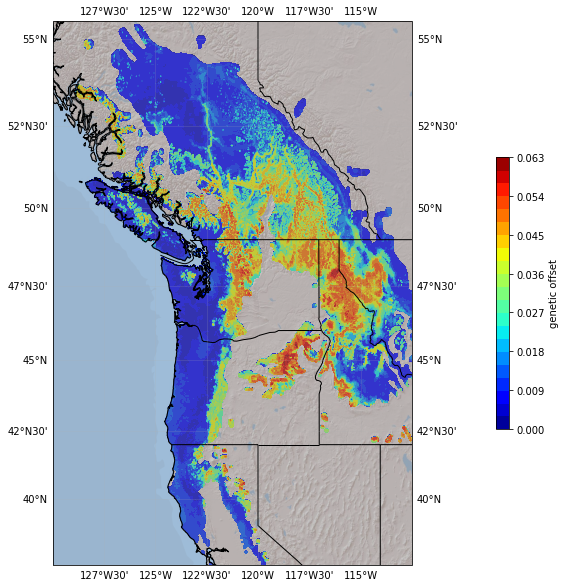

In [49]:
# AFTER REVISION: (see before below, it looks the same right?)
# look at test result
# ncfiles = fs(fitting_dir, endswith='.nc')
# assert len(ncfiles) == 1
# nc = ncfiles[0]

nc = '/data/projects/pool_seq/phenotypic_data/offset_misc_files/fitting/combined-baypass-random-full_gradient_forest_training_NA_ENSEMBLE_rcp45_2050s_all-envs_WGS84_clipped_combined_offset.nc'

ds = xarray.open_dataset(nc)
layers = [var for var in list(ds.variables) if var not in ['crs', 'longitude', 'latitude']]
assert len(layers) == 1
layer = layers[0]
vals = ds[layer][:,:]
lons = ds[layer]['longitude']
lats = ds[layer]['latitude']


ax = basemap(extent=[-130, -112.5, 37.5, 55.5], figsize=(15, 10))

contours = plt.contourf(lons, lats, vals, 20, cmap='jet', transform=ccrs.PlateCarree(), origin='lower')
cb = plt.colorbar(contours, pad=0.1, shrink=0.5)
cb.set_label(f'genetic offset')

# delete test result file
# [os.remove(f) for f in fs(fitting_dir, dirs=False)]

[None, None]

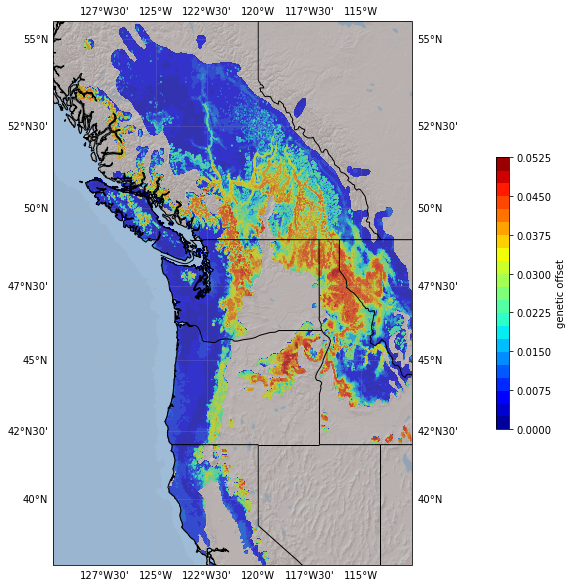

In [35]:
# BEFORE REVISION (not executed, saved from last execution before manuscript submission)
# look at test result
ncfiles = fs(fitting_dir, endswith='.nc')
assert len(ncfiles) == 1
nc = ncfiles[0]

ds = xarray.open_dataset(nc)
layers = [var for var in list(ds.variables) if var not in ['crs', 'longitude', 'latitude']]
assert len(layers) == 1
layer = layers[0]
vals = ds[layer][:,:]
lons = ds[layer]['longitude']
lats = ds[layer]['latitude']


ax = basemap(extent=[-130, -112.5, 37.5, 55.5], figsize=(15, 10))

contours = plt.contourf(lons, lats, vals, 20, cmap='jet', transform=ccrs.PlateCarree(), origin='lower')
cb = plt.colorbar(contours, pad=0.1, shrink=0.5)
cb.set_label(f'genetic offset')

# delete test result files
[os.remove(f) for f in fs(fitting_dir, dirs=False)]

### now in parallel

In [50]:
lview,dview = get_client()  # restart engines to clear up memory

20 20


In [51]:
jobs = []
basenames = []  # make sure I don't make any duplicate basenames
args = []
for spp, rds_files in trained_models.items():
    for training_file, predfile in rds_files:
        maskfile = maskfiles[strans[spp]]
        for projection,spp_range_files in range_files[strans[spp]].items():
            for range_file in spp_range_files:
                range_file = f'/data/projects/pool_seq/environemental_data/new_netCDF_files/{projection}/{range_file}'
                basename = op.basename(training_file).rstrip('.RDS') + '_' + op.basename(range_file).rstrip('.txt')
                assert basename not in basenames
                basenames.append(basename)
                arg = (training_file, range_file, predfile, maskfile, basename, fitting_dir)
                jobs.append(
                    lview.apply_async(fit_model, *arg)
                )
                args.append(arg)

watch_async(jobs)


Watching 532 jobs ...


100%|███████████████| 532/532 [40:08<00:00,  4.53s/it]  


In [52]:
# redo the jobs that failed
count = 0
while True:
    needed = []
    for basename,arg in zip(basenames, args):
        nc = op.join(fitting_dir, basename + '_offset.nc')
        rds = op.join(fitting_dir, basename + '_gradient_forest_fitted.RDS')
        if not all([op.exists(nc), op.exists(rds)]):
            needed.append(arg)

    if len(needed) == 0:
        break

    jobs = []
    for arg in needed:
        jobs.append(
            lview.apply_async(fit_model, *arg)
        )

    watch_async(jobs, desc=f'iteration {count}')

    count += 1


Watching 4 jobs ...


iteration 0: 100%|███████████████| 4/4 [10:17<00:00, 154.26s/it]
